In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler

In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
dataset='navalC'
seed=117
setup_ = get_setup(dataset)
setup = setup_.Setup(device, seed=seed)
x_train, y_train = setup.train_data()

input_dim = x_train.shape[1]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)

std_y_train = torch.tensor(setup.scaler_y.scale_, device=device).squeeze().float()

In [5]:
nb_input_samples = 500
n_epochs = 2000
num_epochs_ensemble = 500
batch_size = 500
patience=20
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()
lat_dim=10
n_samples_VAR = 50


In [6]:
input_sampler = uniform_rect_sampler(x_train, n=nb_input_samples)

model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,
             lat_dim=lat_dim).to(device)
logs, run_time = FuNN_train(model, train_dataset, batch_size, input_sampler, n_epochs=n_epochs,
                        patience=patience, n_samples_VAR =n_samples_VAR)

FuNN-HyVI:  62%|██████▏   | 1234/2000 [10:00<06:13,  2.05it/s, ELBO=-1.53e+3, KL=439, LogLike=1.55e+3, lr=0.0001, sigma=0.0111]  


In [14]:
(batch_size / len(x_train))

0.04655493482309125

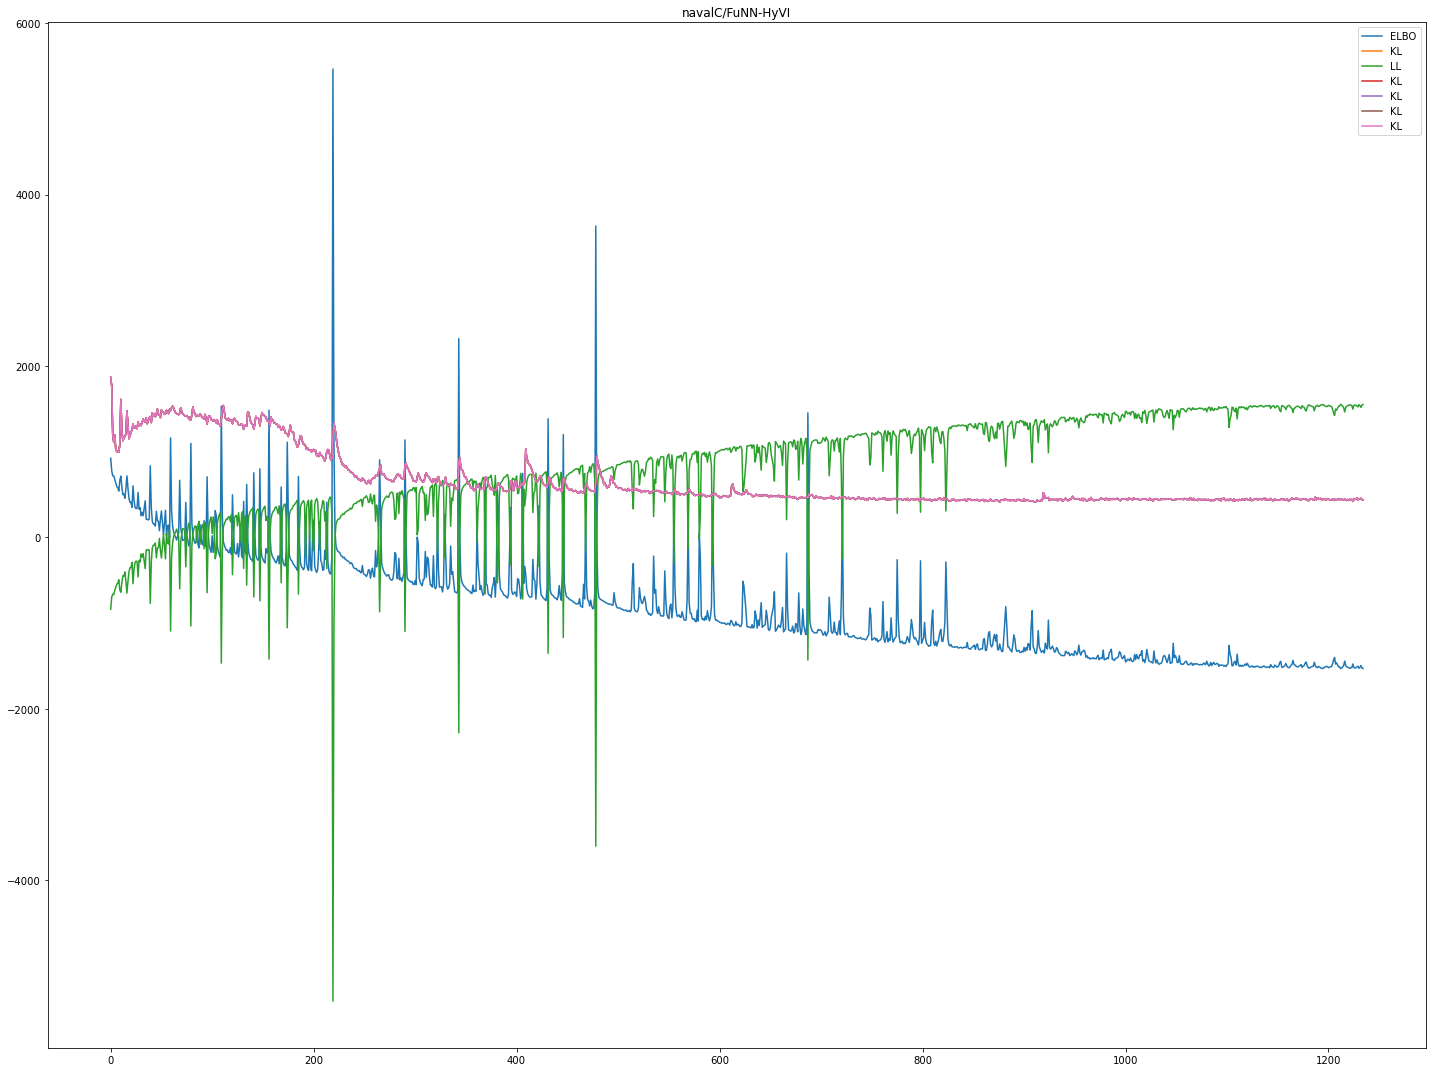

In [23]:
from pylab import *
methods_=['FuNN-HyVI']
method='FuNN-HyVI'
fig, ax=plt.subplots(len(methods_), 1, figsize=(20,15))
#ax=ax.flatten()
i=0
for key in logs.keys():
    if  key=='LL' or key=='ELBO': #key=='KL' or
        ax.plot(range(len(logs[key])), logs[key], label=key)
    key='KL'
    ax.plot(range(len(logs[key])), torch.as_tensor(logs[key]), label=key)

    ax.legend()
    
    ax.set_title(dataset+'/'+method)
i+=1

fig.tight_layout()

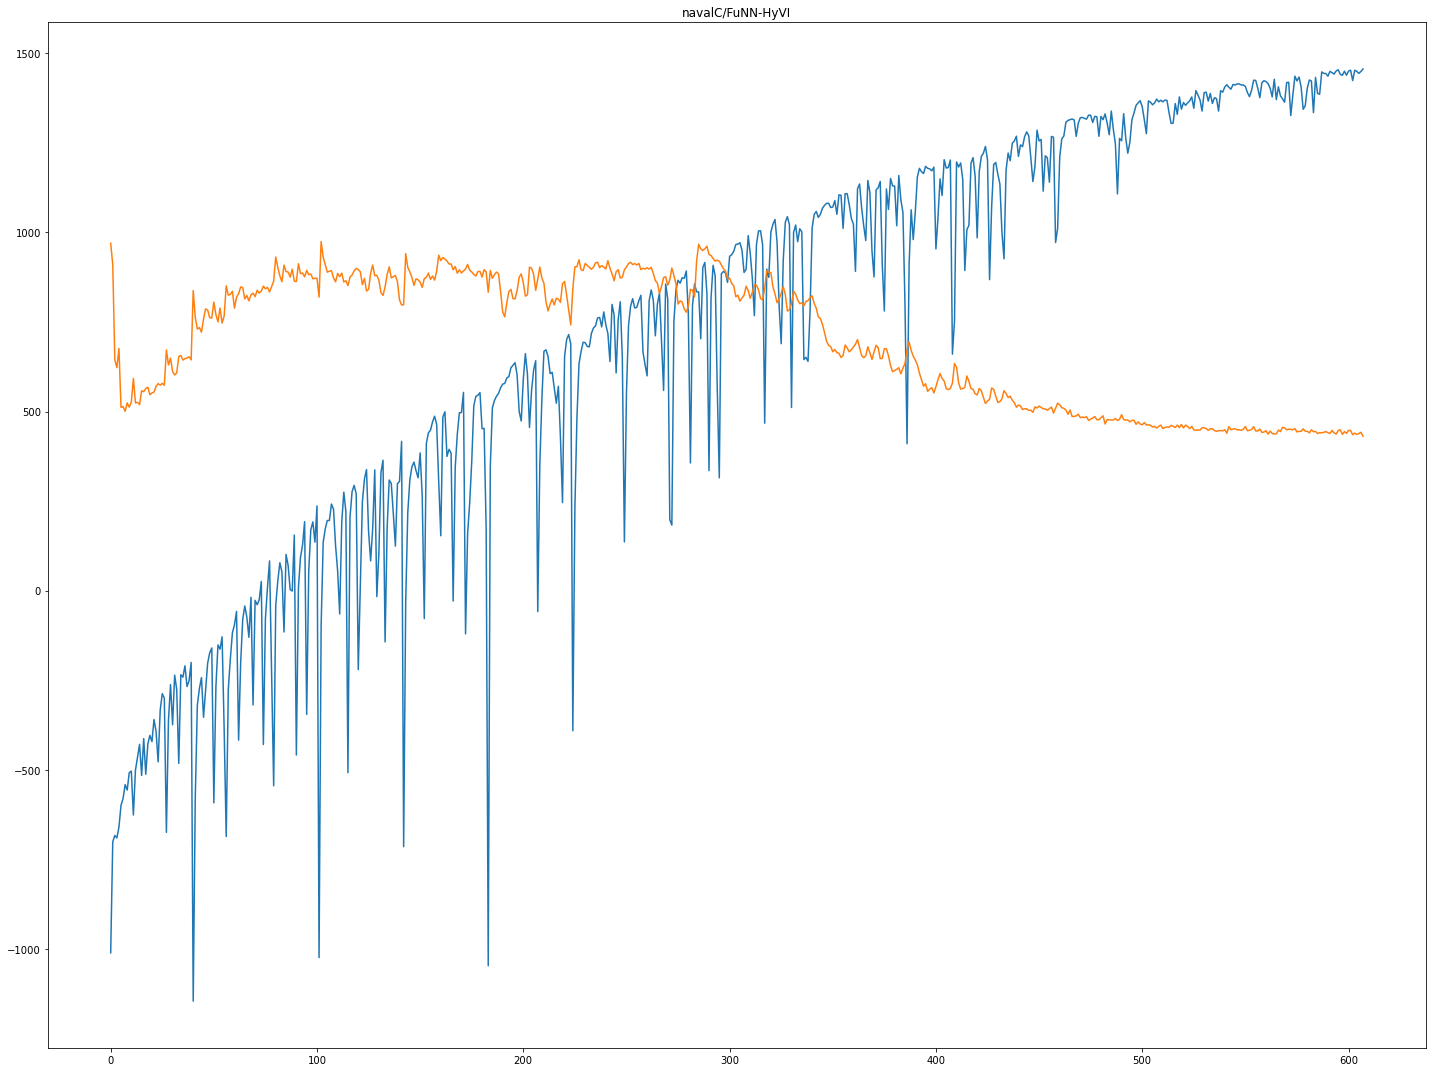

In [16]:
from pylab import *
methods_=['FuNN-HyVI']
method='FuNN-HyVI'
fig, ax=plt.subplots(len(methods_), 1, figsize=(20,15))
#ax=ax.flatten()
i=0
for key in logs.keys():
    if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
        ax.plot(range(len(logs[key])), logs[key])
    #ax[i].legend()
    ax.set_title(dataset+'/'+method)
i+=1

fig.tight_layout()

In [16]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)
nb_predictors=1000
n_MC=200
OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)

method="FuNN-HyVI"
print(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
print(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))


-7985.13623046875
-220.93754348754882


In [17]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [18]:
x_test, y_test = setup.test_data()

y_pred=model(x_test,5)
get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, run_time)

{'RMSE': 0.00014831409498583525,
 'LPP': 7.391482353210449,
 'time [s]': 600.9940719879232,
 'std noise': 0.011102918535470963}

In [12]:
time


<module 'time' (built-in)>